In [1]:
%load_ext autoreload
%autoreload 2

## Test pipeline on one instance


In [2]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [3]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"
pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=10)
print('Input audio:')
display(ipd.Audio(y, rate=sr))

# Use median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic, percussive = pp.apply_median_filtering(spectrogram)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print('Harmonic component:')
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print('Percussive component:')
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


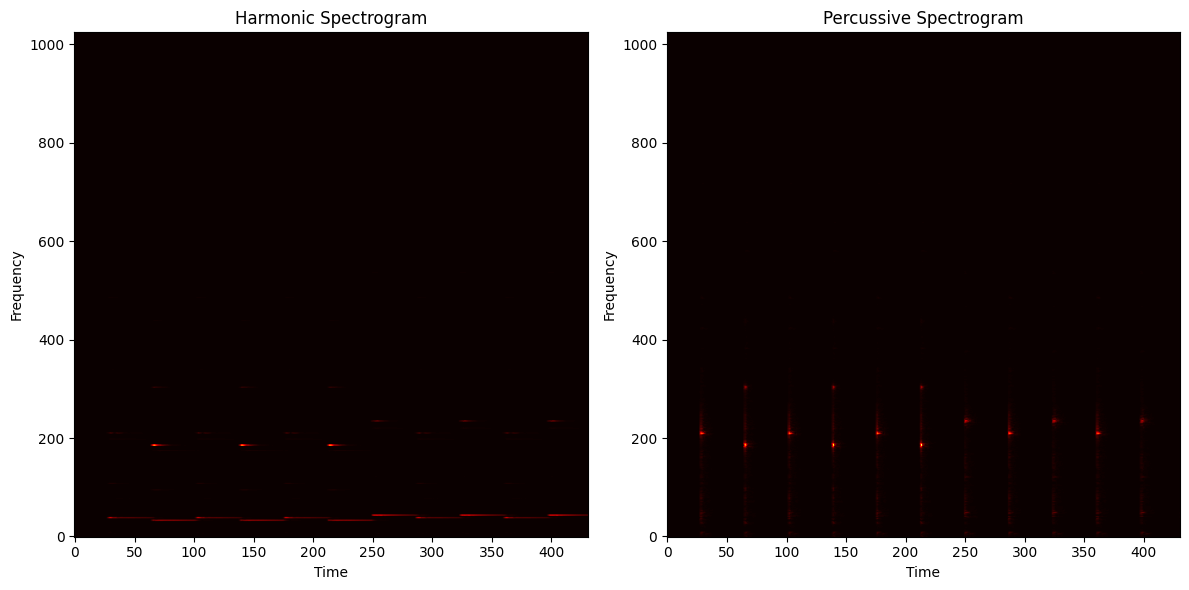

In [4]:
plt.figure(figsize=(12, 6))

# Plot harmonic spectrogram
plt.subplot(1, 2, 1)
plt.imshow(harmonic, aspect='auto', origin='lower', cmap='hot')
plt.title('Harmonic Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

# Plot percussive spectrogram
plt.subplot(1, 2, 2)
plt.imshow(percussive, aspect='auto', origin='lower', cmap='hot')
plt.title('Percussive Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

plt.tight_layout()
plt.show()

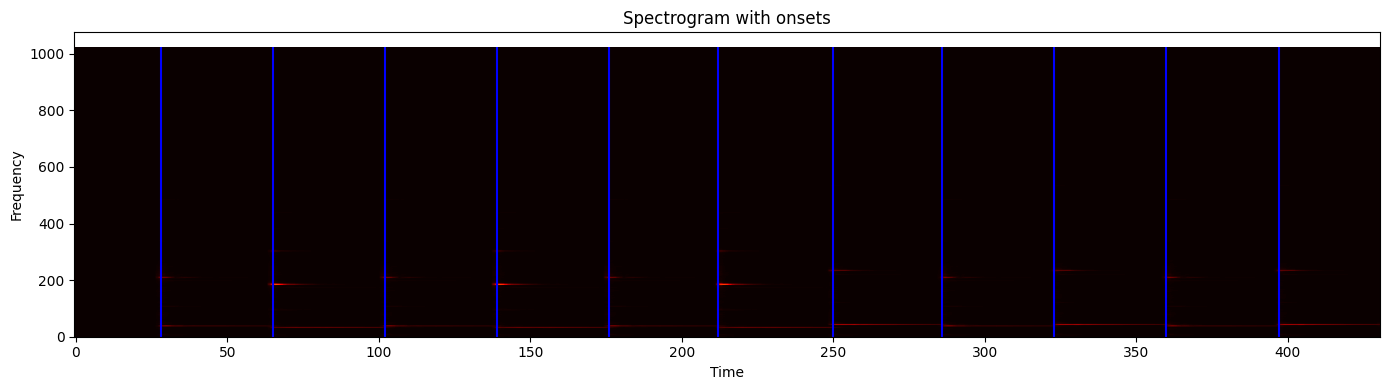

In [5]:
# Assuming you have already computed 'percussive_audio', 'sr', and 'spectrogram'

onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='hot')

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color='blue', linestyle='-')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Spectrogram with onsets')

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [6]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [7]:
time, frequency, confidence, activation = pitch_est.estimate_crepe(harmonic_audio, sr)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step


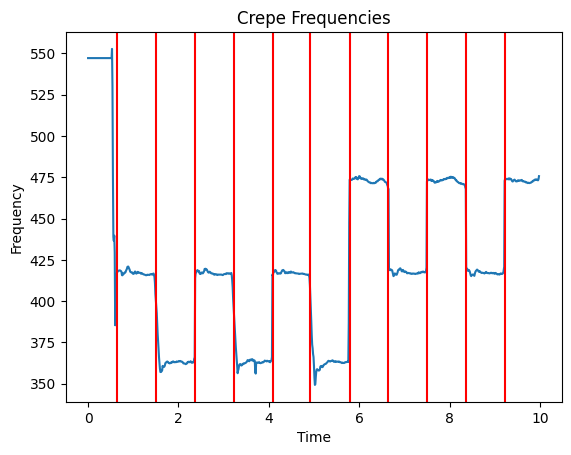

In [8]:
# Plot the interpolated frequencies
plt.plot(time, frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Crepe Frequencies')

for t in onsets:
    plt.axvline(x=round(t, 2), color='r', linestyle='-', label=f'Time {t}')

plt.show()

In [9]:
tones = []
for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1: index_b = len(time) - 1
    else: index_b = np.argmax(time > onsets[i+1])
    frequency_range = frequency[index_a:index_b]
    tone = np.median(frequency_range)
    print(f'Onset {i}-{i+1}: {tone}')
    tones.append(tone)

Onset 0-1: 416.79564078971674
Onset 1-2: 363.0318094220661
Onset 2-3: 416.7108926193727
Onset 3-4: 363.25530958634215
Onset 4-5: 416.9058773179663
Onset 5-6: 363.07622454514143
Onset 6-7: 473.42590697431103
Onset 7-8: 417.403343905117
Onset 8-9: 473.17946202315693
Onset 9-10: 417.04076547173025
Onset 10-11: 473.00968632104383


In [10]:
def group_and_average_frequencies(frequencies, threshold=10):
    frequencies = sorted(frequencies)
    grouped_frequencies = []
    current_group = [frequencies[0]]
    
    for i in range(1, len(frequencies)):
        if frequencies[i] - frequencies[i-1] <= threshold:
            current_group.append(frequencies[i])
        else:
            grouped_frequencies.append(sum(current_group) / len(current_group))
            current_group = [frequencies[i]]
    
    grouped_frequencies.append(sum(current_group) / len(current_group))
    
    return grouped_frequencies

In [11]:
grouped_averaged_frequencies = group_and_average_frequencies(tones)
print(grouped_averaged_frequencies)

[363.12111451784995, 416.9713040207806, 473.2050184395039]
